<a href="https://colab.research.google.com/github/softmurata/promptparty/blob/main/tools/RemoveLittleEverything.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q accelerate bitsandbytes
!pip install git+https://github.com/huggingface/transformers.git
!pip install -q diffusers

In [7]:
!pip install -q controlnet_aux

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.4/202.4 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.3 MB/s eta 0:00:00


In [ ]:
%cd /content

!git clone https://github.com/sczhou/ProPainter.git

!pip install -U openmim
!mim install mmcv
!pip install einop

In [ ]:
!wget https://github.com/sczhou/ProPainter/releases/download/v0.1.0/i3d_rgb_imagenet.pt -P /content/ProPainter/weights
!wget https://github.com/sczhou/ProPainter/releases/download/v0.1.0/ProPainter.pth -P /content/ProPainter/weights
!wget https://github.com/sczhou/ProPainter/releases/download/v0.1.0/raft-things.pth -P /content/ProPainter/weights
!wget https://github.com/sczhou/ProPainter/releases/download/v0.1.0/recurrent_flow_completion.pth -P /content/ProPainter/weights

In [ ]:
# Please change this line in /usr/local/lib/python3.10/dist-packages/transformers/models/oneformer/image_processing_oneformer.py
# 1085, 1086
# after changing, please restart
"""
# class_queries_logits = outputs.class_queries_logits  # [batch_size, num_queries, num_classes+1]
# masks_queries_logits = outputs.masks_queries_logits  # [batch_size, num_queries, height, width]
class_queries_logits = outputs.transformer_decoder_class_predictions
masks_queries_logits = outputs.transformer_decoder_mask_predictions
"""

Remove Everything Pipeline

In [ ]:
# load model
%cd /content/ProPainter

import os
import subprocess
import torch
import numpy as np
import cv2
from PIL import Image
from transformers import AutoProcessor
from transformers import AutoModelForUniversalSegmentation

from diffusers import StableDiffusionXLImg2ImgPipeline
from diffusers.utils import load_image

pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
pipe = pipe.to("cuda")


model_id = "shi-labs/oneformer_ade20k_swin_large"
model = AutoModelForUniversalSegmentation.from_pretrained(model_id)
processor = AutoProcessor.from_pretrained(model_id)

In [15]:
def calculate_bounding_box(mask_image):
    # Find the indices of non-zero pixels within the mask image
    non_zero_pixels = np.transpose(np.nonzero(mask_image))

    if non_zero_pixels.size == 0:
        # Return an empty Bounding Box if there are no non-zero pixels in the mask
        return None

    # Get x and y coordinates
    x_coords, y_coords = non_zero_pixels[:, 0], non_zero_pixels[:, 1]

    # Calculate the Bounding Box coordinates
    min_x, min_y = np.min(x_coords), np.min(y_coords)
    max_x, max_y = np.max(x_coords), np.max(y_coords)

    return (min_x, min_y, max_x, max_y)

def propainter_process_function(project_name, input_path, target_lists):
  cmd = f"rm -rf /content/ProPainter/inputs/object_removal/{project_name}"
  subprocess.call(cmd, shell=True)
  cmd = f"rm -rf /content/ProPainter/inputs/object_removal/{project_name}_mask"
  subprocess.call(cmd, shell=True)


  os.makedirs(f"/content/ProPainter/inputs/object_removal/{project_name}", exist_ok=True)
  os.makedirs(f"/content/ProPainter/inputs/object_removal/{project_name}_mask", exist_ok=True)

  input_name, mimetype = input_path.split(".")

  cmd = f"cp /content/{input_path} /content/ProPainter/inputs/object_removal/{project_name}/"
  subprocess.call(cmd, shell=True)

  image = Image.open(f"/content/ProPainter/inputs/object_removal/{project_name}/{input_path}")

  semantic_inputs = processor(images=image, task_inputs=["semantic"], return_tensors="pt")

  # forward pass
  with torch.no_grad():
    outputs = model(**semantic_inputs)

  semantic_segmentation = processor.post_process_semantic_segmentation(outputs)[0]

  target_label_ids = [model.config.label2id[l] for l in target_lists]
  answer_map = np.zeros_like(semantic_segmentation).astype(np.uint8)
  for target_label_id in target_label_ids:
    target_segmentation_map = np.where(semantic_segmentation == target_label_id, 255, 0)
    answer_map += target_segmentation_map.astype(np.uint8)

  display(Image.fromarray(answer_map))
  Image.fromarray(answer_map).save(f"/content/ProPainter/inputs/object_removal/{project_name}_mask/{input_path}")

  # create frame
  cmd = f"cp /content/ProPainter/inputs/object_removal/{project_name}_mask/{input_path} /content/ProPainter/inputs/object_removal/{project_name}_mask/{input_name}_next.{mimetype}"
  subprocess.call(cmd, shell=True)
  cmd = f"cp /content/ProPainter/inputs/object_removal/{project_name}/{input_path} /content/ProPainter/inputs/object_removal/{project_name}/{input_name}_next.{mimetype}"
  subprocess.call(cmd, shell=True)

  # inference
  cmd = f"python inference_with_image.py --video inputs/object_removal/{project_name} --mask inputs/object_removal/{project_name}_mask"
  subprocess.call(cmd, shell=True)

  display(Image.open(f"/content/ProPainter/results/{project_name}/out.jpg"))

  return answer_map


def refine_with_sdxl_initial(project_name, input_path, answer_map, first_strength=0.2, ablation_ratio=0.01):
  prompt = ""
  img_file = f"/content/ProPainter/results/{project_name}/out.jpg"
  input_name = input_path.split(".")[0]

  init_image = Image.open(img_file).convert("RGB")
  new_image = pipe(prompt, image=init_image, strength=first_strength).images[0]
  display(new_image)
  new_image.save(f"/content/{input_name}_new.jpg")

  bounding_box = calculate_bounding_box(answer_map)  # xmin, ymin, xmax, ymax
  ymin, xmin, ymax, xmax = bounding_box
  bh, bw = answer_map.shape[:2]
  xxmin, xxmax, yymin, yymax = xmin / bw, xmax / bw, ymin / bh, ymax / bh


  base_img = cv2.imread(f"/content/{input_path}")
  bbh, bbw = base_img.shape[:2]
  overlap_img = cv2.resize(cv2.imread(f"/content/{input_name}_new.jpg"), (bbw, bbh))
  oh, ow = overlap_img.shape[:2]

  yomin = max(0, int(yymin * oh * (1 - ablation_ratio)))
  xomin = max(0, int(xxmin * ow * (1 - ablation_ratio)))
  yomax = min(int(yymax * oh * (1 + ablation_ratio)), bbh)
  xomax = min(int(xxmax * ow * (1 + ablation_ratio)), bbw)
  crop_img = overlap_img[yomin:yomax, xomin:xomax, :]
  base_img[yomin:yomax, xomin:xomax, :] = crop_img
  display(Image.fromarray(cv2.cvtColor(base_img, cv2.COLOR_BGR2RGB)))

  return base_img


def refine_with_sdxl_second(input_path, base_img, second_strength=0.1):
  prompt = ""
  init_image = Image.fromarray(cv2.cvtColor(base_img, cv2.COLOR_BGR2RGB))
  new_image = pipe(prompt, image=init_image, strength=second_strength).images[0]
  display(new_image)



/content/ProPainter


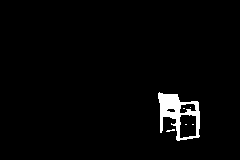

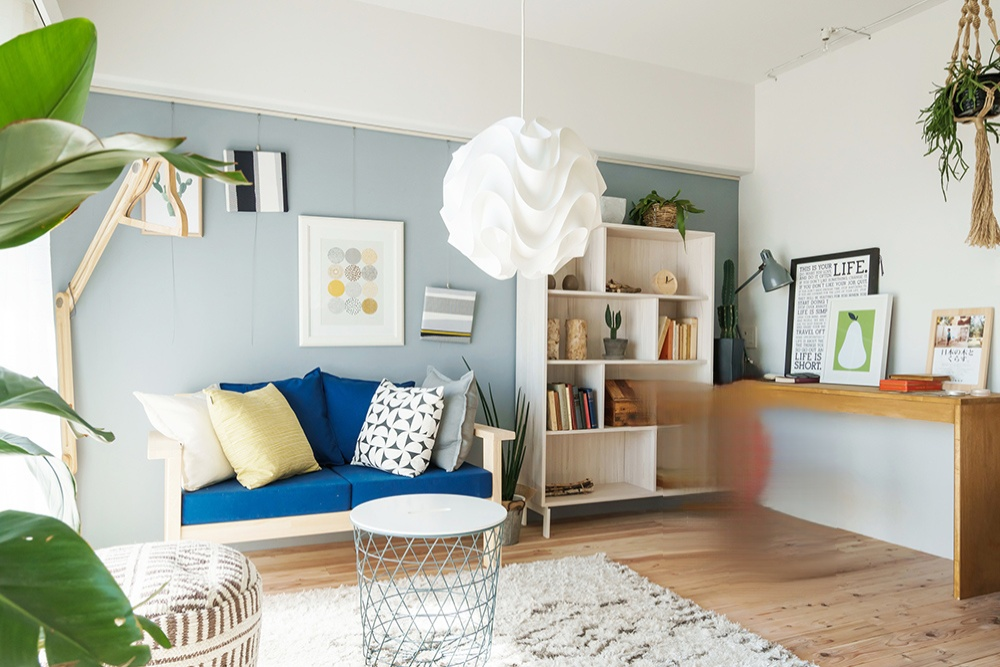

In [6]:
%cd /content/ProPainter
project_name = "room"
input_path = "room001.jpeg"
target_lists = ["chair"]
answer_map = propainter_process_function(project_name, input_path, target_lists)

  0%|          | 0/10 [00:00<?, ?it/s]

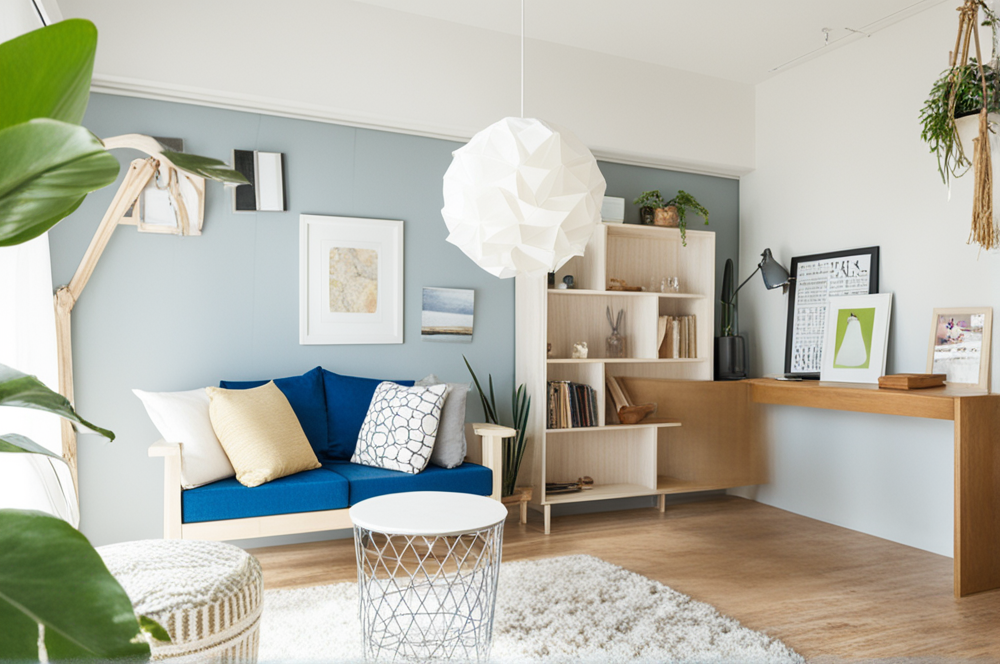

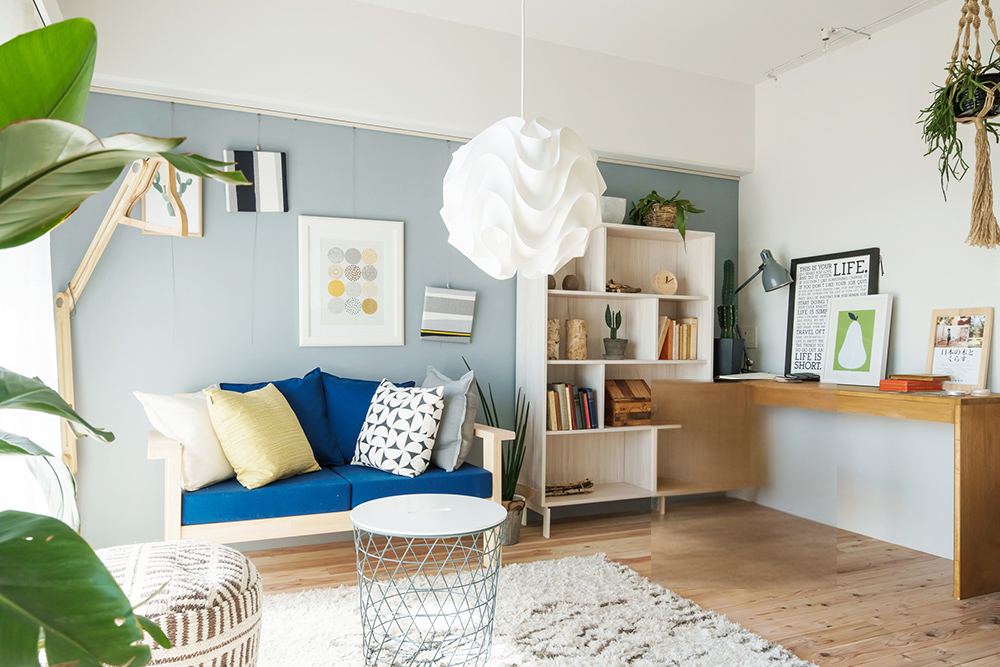

In [16]:
base_img = refine_with_sdxl_initial(project_name, input_path, answer_map, first_strength=0.2, ablation_ratio=0.01)

  0%|          | 0/5 [00:00<?, ?it/s]

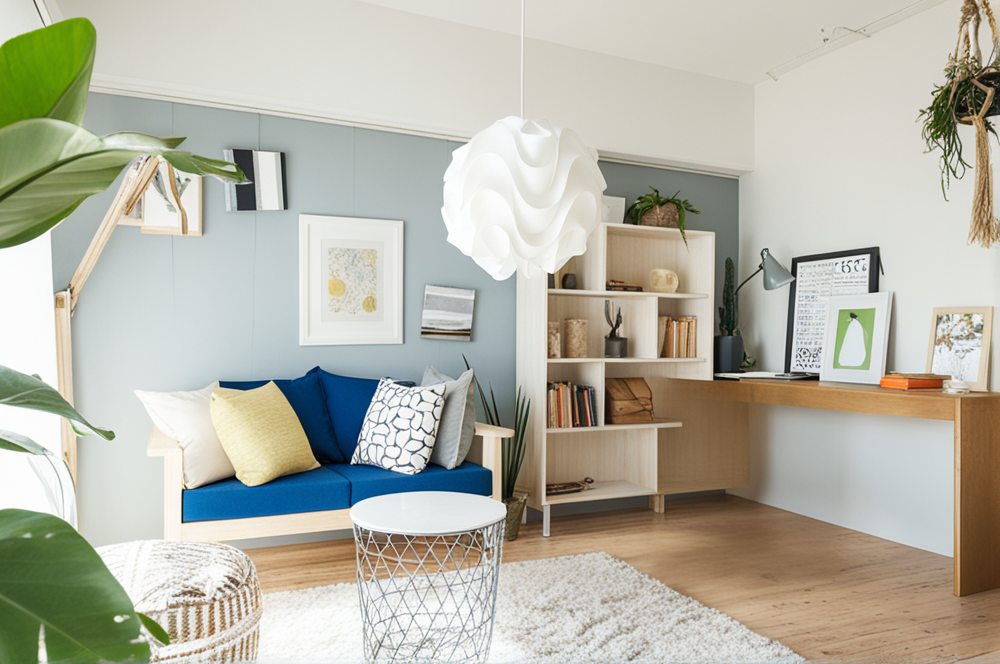

In [17]:
refine_with_sdxl_second(input_path, base_img, second_strength=0.1)

Controlnet Inpaint Removing Pipeline

In [1]:
import torch
import os
from PIL import Image
import numpy as np
import cv2
from transformers import OneFormerProcessor, OneFormerModel
from torch import autocast
from diffusers import StableDiffusionControlNetInpaintPipeline, ControlNetModel, UniPCMultistepScheduler
from controlnet_aux import MLSDdetector

/usr/local/lib/python3.10/dist-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


In [ ]:
# load oneformer model
model_id = "shi-labs/oneformer_ade20k_swin_large"
processor = OneFormerProcessor.from_pretrained(model_id)
model = OneFormerModel.from_pretrained(model_id)

# load stable diffusion model
model_id = "SG161222/Realistic_Vision_V5.1_noVAE"
device = "cuda"

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-mlsd", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    model_id, controlnet=controlnet, torch_dtype=torch.float16
)

pipe.sceduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to(device)

preprocessor = MLSDdetector.from_pretrained("lllyasviel/Annotators")

In [3]:
def calculate_bounding_box(mask_image):
    # Find the indices of non-zero pixels within the mask image
    non_zero_pixels = np.transpose(np.nonzero(mask_image))

    if non_zero_pixels.size == 0:
        # Return an empty Bounding Box if there are no non-zero pixels in the mask
        return None

    # Get x and y coordinates
    x_coords, y_coords = non_zero_pixels[:, 0], non_zero_pixels[:, 1]

    # Calculate the Bounding Box coordinates
    min_x, min_y = np.min(x_coords), np.min(y_coords)
    max_x, max_y = np.max(x_coords), np.max(y_coords)

    return (min_x, min_y, max_x, max_y)

In [ ]:
print(model.config.label2id.keys())

In [5]:
image = Image.open(f"/content/room001.jpeg")

inputs = processor(image, ["semantic"], return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

# you can pass them to processor for semantic postprocessing
predicted_semantic_map = processor.post_process_semantic_segmentation(
      outputs, target_sizes=[image.size[::-1]]
)[0]

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
label_name = "shelf"

seg_id = model.config.label2id[label_name]
label_pred_map = np.where(predicted_semantic_map == seg_id, 255, 0)

display(Image.fromarray(label_pred_map.astype(np.uint8)))

In [7]:
bounding_box = calculate_bounding_box(label_pred_map)  # xmin, ymin, xmax, ymax
ymin, xmin, ymax, xmax = bounding_box

In [ ]:
mask_image = np.zeros_like(label_pred_map)
mask_image[ymin:ymax, xmin:xmax] = 255
bh, bw = mask_image.shape[:2]

yymin, yymax, xxmin, xxmax = ymin / bh, ymax / bh, xmin / bw, xmax / bw

display(Image.fromarray(mask_image.astype(np.uint8)))

pre_image = cv2.imread(f"/content/room001.jpeg")
pre_image = Image.fromarray(cv2.cvtColor(pre_image, cv2.COLOR_BGR2RGB))
pre_image = preprocessor(pre_image)
pre_image = np.array(pre_image, dtype=np.uint8)
ph, pw = pre_image.shape[:2]
pre_image[int(yymin * ph): int(yymax * ph), int(xxmin * pw): int(xxmax * pw), :] = 0
display(Image.fromarray(pre_image))

In [23]:
size = (512, 512)
image = Image.open(f"/content/room001.jpeg").resize(size)
mask_image = Image.fromarray(mask_image.astype(np.uint8)).resize(size)
pre_image = Image.fromarray(pre_image).resize(size)

  0%|          | 0/50 [00:00<?, ?it/s]

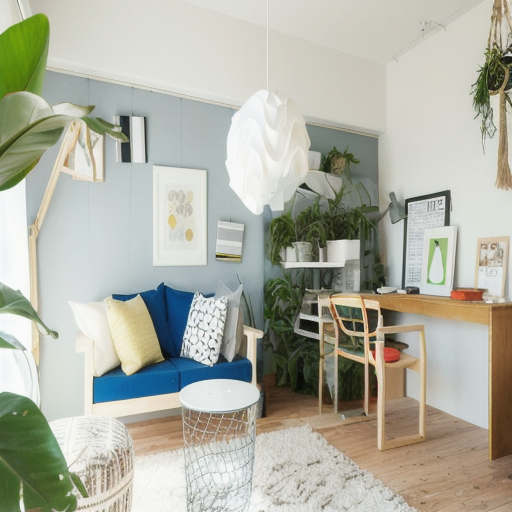

In [27]:
text_prompt = "wall"
seed = -1

generator = torch.manual_seed(seed)

new_image = pipe(
    text_prompt,
    num_inference_steps=50,
    generator=generator,
    strength=1,
    image=image,
    control_image=pre_image,
    mask_image=mask_image
).images[0]

display(new_image)